#week 10 - information theory

In [1]:
print("hellow world! ")

hellow world! 


In [2]:
import zlib #also lzma


text = "here is some text some text text text with repitition"
print(f"Original text{len(text)} bytes: ",text)

text_bytes = text.encode('ascii')
comp = zlib.compress(text_bytes)
print(f"Compressed text {len(comp)} bytes: ",comp)

decomp= zlib.decompress(comp)
print("decompressed text :", decomp.decode('ascii'))
ratio = len(comp)/len(text_bytes)
print(f"compression ration: {ratio:.2f}")

Original text53 bytes:  here is some text some text text text with repitition
Compressed text 42 bytes:  b'x\x9c\xcbH-JU\xc8,V(\xce\xcfMU(I\xad(Ab!\x88\xf2\xcc\x92\x0c\x85\xa2\xd4\x82\xcc\x12 \xcc\xcf\x03\x00\x13>\x14 '
decompressed text : here is some text some text text text with repitition
compression ration: 0.79


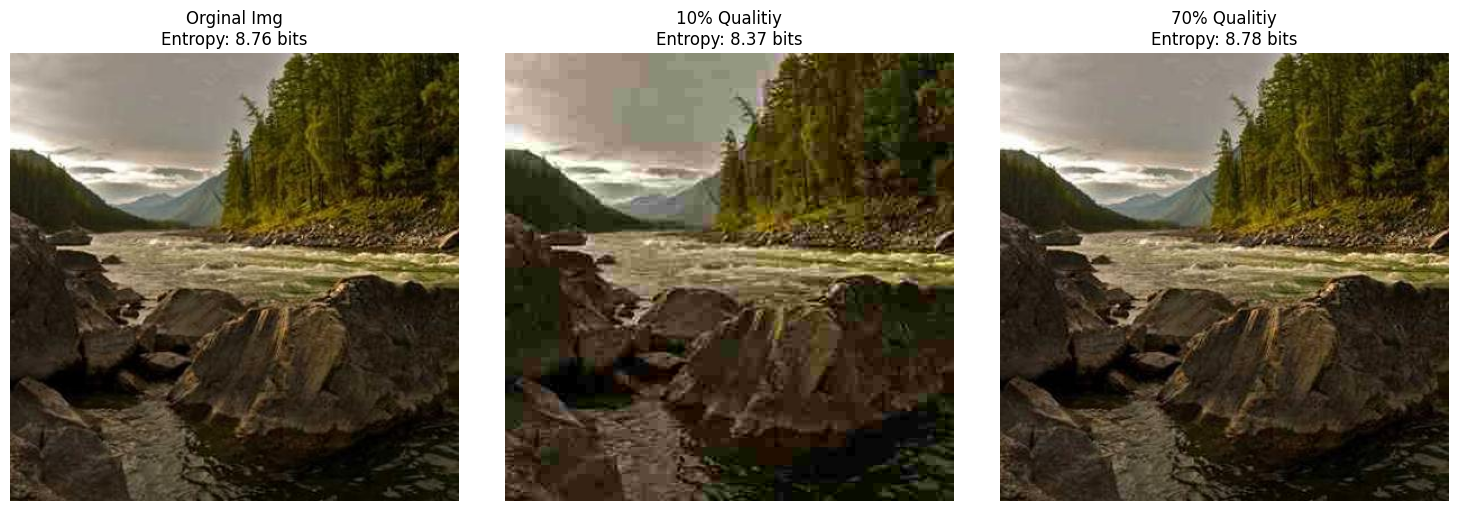

In [3]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

def entropy(img):
    histogram = img.histogram()
    probs = [float(h) / sum(histogram) for h in histogram]
    return -sum(p * np.log2(p) for p in probs if p != 0)

def compress(img, quality=75):
    fname = f'images/q_{quality}.jpg'
    img.save(fname,'JPEG', quality=quality)
    compressed = Image.open(fname)
    return compressed,entropy(compressed)

url = 'https://picsum.photos/400/400'
response = requests.get(url)
orginal = Image.open(BytesIO(response.content))

qualities = [10,70]
images = [orginal]
entropyies=[entropy(orginal)]
titles = ['Orginal Img']
for q in qualities:
    img_c, img_h = compress(orginal,q)
    images.append(img_c)
    entropyies.append(img_h)
    titles.append(f'{q}% Qualitiy')

plt.figure(figsize= (15,5))
for lcv,(img,ent,title) in enumerate(zip(images,entropyies,titles), start=1):
    plt.subplot(1,len(images),lcv)
    plt.imshow(img)
    plt.title(f"{title}\nEntropy: {ent:.2f} bits")
    plt.axis('off')
plt.tight_layout()
plt.show()


# Week 11 - Newtwork Simulation 

In [4]:
%pip install faker tqdm
from tqdm import tqdm
from queue import Queue
from faker import Faker
from time import time, sleep


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
class Device:
    def __init__(self,name):
        self.ip = ""
        self.name=name
        self.inbox = Queue()

    def send(self, recip, msg):
        print(f"{self.name} is sending {len (msg)} bytes to {recip.ip}")
        for _ in tqdm(range(len(msg)), desc="Sending", ncols=100):
            sleep(0.25)
        recip.inbox.put(msg.encode('ascii'))

    def receive(self):
        if not self.inbox.empty():
            msg=self.inbox.get().decode('ascii')
            print(f"{self.name} recevied a message: {msg}")
            return len(msg)
        return 0

In [6]:
# part 2 to the code above^^^^
class Network:
    def __init__(self):
        self.devices = []
        self.dhcp = Faker()
        self.start_time=time()
        self.usage = 0

    def add_device(self,device: Device):
        device.ip = self.dhcp.ipv4()
        self.devices.append(device)

    def sim_traffic(self):
        for device in self.devices:
            self.usage += device.receive()

    def display(self):
        print(f"Uptime: {time()-self.start_time:.4} seconds")
        print(f"Data usage: {self.usage} bytes")
        print("connected devices: ")
        for d in self.devices:
            print(f"{d.name} \t\t {d.ip}")

In [8]:
alice = Device("Alice")
bob = Device("Bob")

net= Network()
net.add_device(alice)
net.add_device(bob)
net.display()

while True:
    sender_name = input("Who are you (Alice/Bob)?")
    if sender_name == "Alice":
        sender, recip = alice,bob
    elif sender_name == "Bob":
        sender,recip = bob, alice
    else:
        print("Invalid name")
        continue

    msg = input("Enter your message: ")
    sender.send(recip, msg)
    net.sim_traffic()

    loop = input("do you want to send another message (y/n): ")
    if loop not in "yes":
        break

net.display()

Uptime: 0.009022 seconds
Data usage: 0 bytes
connected devices: 
Alice 		 96.94.186.91
Bob 		 89.49.62.238
Alice is sending 5 bytes to 89.49.62.238


Sending: 100%|████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.98it/s]


Bob recevied a message: weeee
Uptime: 12.81 seconds
Data usage: 5 bytes
connected devices: 
Alice 		 96.94.186.91
Bob 		 89.49.62.238


# Week 12 internet 

In [ ]:
%pip instal fakier tqdm termcolor -q
import random
from tqdm import tqdm
from time import sleep 
from faker import Faker
from termcolor import colored

def print_sleep(msg,seconds=1):
    print(msg)
    print(sleep)

def do_progress(length,desc,seconds=0.05):
    for _ in tqdm(range (length), desc=desc, ncols=100):
        sleep(seconds)

In [ ]:
class ApplicationLayer:
    def __init__(self,data):
        self.data = data

    def prepare_data(self):
        print_sleep(colored("Application Layer: ", "cyan")+ 
                    f"Preparing data '{self.data}'")
        return self.data.encode()
    
    class TransportLayer:
        def __init__(self, protocol="TCP", port=80):
            self.protocol = protocol
            self.prot=port
            self.sequence_num = random.randint(1,100)

        def prepare_segment(self,data):
            header = colored("Transport Layer: ", "magenta")
            if self.protocol == "TCP":
                print_sleep(header + f"Using TCP on port {self.port} - Establish connection...")
                # TCP handshake
                print_sleep(header + f"SYN packet (seq= {self.sequence_num})", 0.5)
                print_sleep(header + f"SYN packet (seq= {self.sequence_num+1})", 0.5)
                print_sleep(header + f"ACK packet - connection established ", 0.5)
            else:
                print(header + f"Using UDP on port {self.port} - No connection setup reqired.")

            segment = f"{self.protocol}--Port--{self.port}--segment--{self.sequence_num}|{data.decode()}"
            do_progress(len(segment), "Transport Layer Proccesing")
            return segment.encode()